In [1]:
# ===============================
# 📦 CELL 1: INSTALL PACKAGES (FIXED VERSION)
# ===============================
# Install core packages first
!pip install transformers datasets torch scikit-learn matplotlib seaborn tqdm gensim nltk -q
# Fix numpy compatibility
!pip install --upgrade --force-reinstall numpy==1.26.4 -q
!pip install --upgrade --force-reinstall scikit-learn==1.3.2 -q

import numpy as np
import subprocess, sys

def ensure_numpy_compat():
    import numpy as np
    version = tuple(map(int, np.__version__.split(".")[:2]))
    if version >= (2,0):
        print(f"⚠️ Detected numpy {np.__version__}, downgrading to 1.26.4 for compatibility...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "--force-reinstall", "numpy==1.26.4"])
        print("✅ Numpy fixed. Please restart the runtime now!")

ensure_numpy_compat()

# Install Vietnamese NLP packages with error handling
import subprocess
import sys

def install_with_fallback(package_name, fallback_msg=""):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name, "-q"])
        print(f"✅ {package_name} installed successfully")
        return True
    except subprocess.CalledProcessError as e:
        print(f"⚠️ Failed to install {package_name}: {e}")
        if fallback_msg:
            print(f"   {fallback_msg}")
        return False

# Try to install Vietnamese packages
print("📦 Installing Vietnamese NLP packages...")
pyvi_available = install_with_fallback("pyvi", "Will use basic tokenization instead")
underthesea_available = install_with_fallback("underthesea", "Will use alternative tokenization")

# Optional packages
install_with_fallback("wordcloud", "Word cloud generation will be skipped")

print("\n✅ Core packages installed successfully!")
print(f"📊 PyVi available: {pyvi_available}")
print(f"📊 Underthesea available: {underthesea_available}")

# Alternative minimal installation if Vietnamese packages fail
if not pyvi_available and not underthesea_available:
    print("\n⚠️ Vietnamese tokenizers not available - using basic preprocessing")
    print("This will still work but with reduced Vietnamese text processing quality")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.3.2 which is incompatible.
imbalanced-learn 0.14.0 requires scikit-learn<2,>=1.4.2, but you have scikit-learn 1.3.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
opencv-python

In [2]:
# ===============================
# 📂 CELL 2: MOUNT DRIVE & IMPORTS
# ===============================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import torch
import warnings
import re
import html
import os
import pickle
import joblib
from collections import Counter
warnings.filterwarnings('ignore')

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding,
    EarlyStoppingCallback, AutoConfig
)
from datasets import Dataset

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt', quiet=True)

# Vietnamese text processing
try:
    from pyvi import ViTokenizer
    PYVI_AVAILABLE = True
except ImportError:
    print("⚠️ PyVi not available, will use basic tokenization")
    PYVI_AVAILABLE = False

try:
    from underthesea import word_tokenize
    UNDERTHESEA_AVAILABLE = True
except ImportError:
    print("⚠️ Underthesea not available, will use alternative tokenization")
    UNDERTHESEA_AVAILABLE = False

print("✅ All imports successful!")


🔥 Using device: cuda
GPU: Tesla T4
Memory: 14.7 GB
⚠️ Underthesea not available, will use alternative tokenization
✅ All imports successful!


In [4]:
# ===============================
# 🔧 CELL 3: ADVANCED VIETNAMESE TEXT PREPROCESSOR
# ===============================
class AdvancedVietnameseTextPreprocessor:
    def __init__(self):
        self.html_tags = re.compile('<.*?>')

        # Vietnamese stopwords (expanded list)
        self.vietnamese_stopwords = {
            'và', 'là', 'có', 'được', 'này', 'đó', 'các', 'một', 'không', 'để', 'trong',
            'của', 'với', 'về', 'từ', 'theo', 'như', 'trên', 'dưới', 'sau', 'trước',
            'đã', 'sẽ', 'đang', 'bị', 'cho', 'tại', 'do', 'vì', 'nên', 'mà', 'hay',
            'hoặc', 'nhưng', 'tuy', 'dù', 'nếu', 'khi', 'lúc', 'bây_giờ', 'hiện_tại',
            'ngày', 'tháng', 'năm', 'giờ', 'phút', 'giây', 'rồi', 'đây', 'kia'
        }

        # Common replacements for text normalization
        self.replacements = {
            # Number normalization
            r'\d{1,2}[/.-]\d{1,2}[/.-]\d{2,4}': ' <DATE> ',  # dates
            r'\d+[.,]\d+': ' <NUMBER> ',  # decimal numbers
            r'\d+': ' <NUMBER> ',  # integers

            # Special characters normalization
            r'[!]{2,}': ' <EXCLAMATION> ',
            r'[?]{2,}': ' <QUESTION> ',
            r'[.]{3,}': ' <DOTS> ',

            # Repeated characters
            r'(.)\1{2,}': r'\1\1',  # reduce repeated chars to max 2
        }

        # Common fake news indicators in Vietnamese
        self.fake_indicators = {
            'nóng', 'hot', 'shock', 'khẩn_cấp', 'cảnh_báo', 'nguy_hiểm',
            'bí_mật', 'tiết_lộ', 'phát_hiện', 'đột_phá', '100%', 'chắc_chắn',
            'tuyệt_đối', 'không_bao_giờ', 'luôn_luôn', 'mãi_mãi'
        }

    def clean_html(self, text):
        """Advanced HTML cleaning"""
        if pd.isna(text):
            return ""

        # Decode HTML entities
        text = html.unescape(str(text))

        # Remove HTML tags but keep some structure
        text = self.html_tags.sub(' ', text)

        # Remove script and style content
        text = re.sub(r'<script[^>]*>.*?</script>', '', text, flags=re.DOTALL | re.IGNORECASE)
        text = re.sub(r'<style[^>]*>.*?</style>', '', text, flags=re.DOTALL | re.IGNORECASE)

        return text

    def normalize_text(self, text):
        """Advanced text normalization"""
        if pd.isna(text):
            return ""

        text = str(text).lower()

        # Apply replacements
        for pattern, replacement in self.replacements.items():
            text = re.sub(pattern, replacement, text)

        # Remove URLs and emails
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' <URL> ', text)
        text = re.sub(r'\S+@\S+', ' <EMAIL> ', text)

        # Remove phone numbers
        text = re.sub(r'(\+84|0)[0-9]{9,10}', ' <PHONE> ', text)

        # Normalize whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_vietnamese(self, text):
        """Vietnamese-aware tokenization"""
        if pd.isna(text) or not text.strip():
            return []

        # Use Vietnamese tokenizer if available
        if UNDERTHESEA_AVAILABLE:
            try:
                tokens = word_tokenize(text)
                return [token for token in tokens if len(token) > 1]
            except:
                pass

        if PYVI_AVAILABLE:
            try:
                tokenized = ViTokenizer.tokenize(text)
                return [token for token in tokenized.split() if len(token) > 1]
            except:
                pass

        # Fallback to simple tokenization
        return simple_preprocess(text, min_len=2, max_len=50)

    def remove_stopwords(self, tokens):
        """Remove Vietnamese stopwords"""
        return [token for token in tokens if token not in self.vietnamese_stopwords]

    def extract_features(self, text):
        """Extract linguistic features"""
        features = {
            'length': len(str(text)),
            'word_count': len(str(text).split()),
            'avg_word_length': np.mean([len(word) for word in str(text).split()]) if str(text).split() else 0,
            'exclamation_count': str(text).count('!'),
            'question_count': str(text).count('?'),
            'uppercase_ratio': sum(1 for c in str(text) if c.isupper()) / len(str(text)) if str(text) else 0,
            'digit_count': sum(1 for c in str(text) if c.isdigit()),
            'fake_indicator_count': sum(1 for word in str(text).lower().split() if word in self.fake_indicators)
        }
        return features

    def clean_and_process(self, text, remove_stopwords=False, extract_features=False):
        """Complete text processing pipeline"""
        # Clean HTML
        clean_text = self.clean_html(text)

        # Normalize
        normalized = self.normalize_text(clean_text)

        # Extract features if requested
        features = self.extract_features(normalized) if extract_features else None

        # Tokenize
        tokens = self.tokenize_vietnamese(normalized)

        # Remove stopwords if requested
        if remove_stopwords:
            tokens = self.remove_stopwords(tokens)

        processed_text = ' '.join(tokens)

        return processed_text, features

print("✅ Advanced Vietnamese Text Preprocessor defined!")


✅ Advanced Vietnamese Text Preprocessor defined!


In [5]:
# ===============================
# 📋 CELL 4: ENHANCED DATASET PREPROCESSOR
# ===============================
class EnhancedNewsDatasetPreprocessor:
    def __init__(self):
        self.text_preprocessor = AdvancedVietnameseTextPreprocessor()
        self.feature_scaler = StandardScaler()

    def combine_text_features(self, df, use_weights=True):
        """Enhanced text combination with weights"""
        combined_texts = []
        linguistic_features = []

        # Weights for different text components
        weights = {
            'title': 3.0,      # Title is most important
            'summary': 2.0,    # Summary is very important
            'content': 1.0     # Content is baseline
        }

        for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing texts"):
            text_parts = []
            row_features = {}

            # Process title
            if pd.notna(row.get('title')) and str(row.get('title')).strip():
                title_clean, title_feat = self.text_preprocessor.clean_and_process(
                    row['title'], remove_stopwords=False, extract_features=True
                )
                if title_clean:
                    if use_weights:
                        text_parts.extend([title_clean] * int(weights['title']))
                    else:
                        text_parts.append(title_clean)
                    row_features.update({f'title_{k}': v for k, v in title_feat.items()})

            # Process summary
            if pd.notna(row.get('summary')) and str(row.get('summary')).strip():
                summary_clean, summary_feat = self.text_preprocessor.clean_and_process(
                    row['summary'], remove_stopwords=False, extract_features=True
                )
                if summary_clean:
                    if use_weights:
                        text_parts.extend([summary_clean] * int(weights['summary']))
                    else:
                        text_parts.append(summary_clean)
                    row_features.update({f'summary_{k}': v for k, v in summary_feat.items()})

            # Process content
            if pd.notna(row.get('content_html')) and str(row.get('content_html')).strip():
                content_clean, content_feat = self.text_preprocessor.clean_and_process(
                    row['content_html'], remove_stopwords=False, extract_features=True
                )
                if content_clean:
                    text_parts.append(content_clean)
                    row_features.update({f'content_{k}': v for k, v in content_feat.items()})

            # Combine texts
            combined_text = ' [SEP] '.join(text_parts) if text_parts else ""
            combined_texts.append(combined_text)
            linguistic_features.append(row_features)

        return combined_texts, linguistic_features

    def prepare_data(self, df, min_length=50, max_length=8000, balance_data=False):
        """Enhanced data preparation with optional balancing"""
        print("📋 Enhanced preprocessing...")

        # Combine texts and extract features
        combined_texts, linguistic_features = self.combine_text_features(df)
        df['combined_text'] = combined_texts

        # Add linguistic features to dataframe
        if linguistic_features and linguistic_features[0]:  # Check if features exist
            feature_df = pd.DataFrame(linguistic_features)
            df = pd.concat([df, feature_df], axis=1)

        # Filter by text length
        df['text_length'] = df['combined_text'].str.len()

        print(f"📊 Original dataset: {len(df)} samples")

        # Remove texts that are too short or too long
        df = df[(df['text_length'] >= min_length) & (df['text_length'] <= max_length)]

        # Remove empty texts
        df = df[df['combined_text'].str.strip() != '']

        print(f"📊 After length filtering: {len(df)} samples")

        # Balance dataset if requested
        if balance_data:
            df = self.balance_dataset(df)

        # Ensure labels are binary
        df['label'] = df['label'].astype(int)

        print(f"📊 Final dataset: {len(df)} samples")
        print(f"📊 Label distribution:")
        print(df['label'].value_counts())
        print(f"📊 Text length statistics:")
        print(df['text_length'].describe())

        return df

    def balance_dataset(self, df):
        """Balance dataset using undersampling"""
        print("⚖️ Balancing dataset...")

        # Get minority class size
        label_counts = df['label'].value_counts()
        min_size = label_counts.min()

        # Sample equal amounts from each class
        balanced_dfs = []
        for label in df['label'].unique():
            class_df = df[df['label'] == label].sample(n=min_size, random_state=42)
            balanced_dfs.append(class_df)

        balanced_df = pd.concat(balanced_dfs, ignore_index=True)

        print(f"📊 Balanced dataset: {len(balanced_df)} samples")
        print(f"📊 New label distribution:")
        print(balanced_df['label'].value_counts())

        return balanced_df

print("✅ Enhanced Dataset Preprocessor defined!")

✅ Enhanced Dataset Preprocessor defined!


In [6]:
# ===============================
# CELL 5: 🤖 UNIVERSAL TRANSFORMER CLASSIFIER (FIXED INDENTATION)
# ===============================
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class UniversalTransformerClassifier:

    def __init__(self, model_name: str, max_length: int = 512, num_labels: int = 2, from_scratch: bool = False):
        self.model_name = model_name
        self.max_length = max_length
        self.num_labels = num_labels
        self.from_scratch = from_scratch

        print(f"\n🤖 Initializing {model_name} (from_scratch={from_scratch}) ...")

        # tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

        # model
        if from_scratch:
            config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
            self.model = AutoModelForSequenceClassification.from_config(config)
            print(f"⚠️ Model {model_name} initialized with RANDOM weights.")
        else:
            self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
            print(f"✅ Model {model_name} loaded pretrained weights.")

        self.model.to(device)
        self.history = None
        self.best_epoch = None

    def encode(self, texts, labels=None):
        """Tokenize list[str] -> TensorDataset."""
        if isinstance(texts, str):
            texts = [texts]

        enc = self.tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = enc["input_ids"]
        attention_mask = enc["attention_mask"]

        if labels is not None:
            labels_arr = torch.tensor(labels, dtype=torch.long)
            return TensorDataset(input_ids, attention_mask, labels_arr)
        else:
            return TensorDataset(input_ids, attention_mask)

    def train(self, train_texts, train_labels, val_texts, val_labels,
              num_epochs: int = 15,
              batch_size: int = 16,
              learning_rate: float = 2e-5,
              weight_decay: float = 0.0,
              save_best: bool = True,
              best_save_dir: str = "./best_model"):

        print(f"\n🚀 Training {self.model_name} for {num_epochs} epochs (from_scratch={self.from_scratch})")

        # dataloaders
        train_ds = self.encode(train_texts, train_labels)
        val_ds   = self.encode(val_texts, val_labels)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        optimizer = AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        loss_fn = nn.CrossEntropyLoss()

        best_val_f1 = -1.0
        best_state = None
        best_preds, best_labels = None, None
        saved_path = None
        decrease_count = 0

        # history
        self.history = {"train_loss": [], "val_acc": [], "val_prec": [], "val_rec": [], "val_f1": [], "val_auc": []}

        for epoch in range(1, num_epochs + 1):
            # ---- training ----
            self.model.train()
            total_loss = 0.0
            for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Training", leave=False):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                optimizer.zero_grad()
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_train_loss = total_loss / max(1, len(train_loader))

            # ---- validation ----
            self.model.eval()
            val_preds, val_labels_all, val_probs = [], [], []
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} - Validation", leave=False):
                    input_ids, attention_mask, labels = [b.to(device) for b in batch]
                    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                    logits = outputs.logits
                    probs = torch.softmax(logits, dim=1).cpu().numpy()
                    preds = np.argmax(probs, axis=1)

                    val_preds.extend(preds.tolist())
                    val_labels_all.extend(labels.cpu().numpy().tolist())
                    val_probs.extend(probs.tolist())

            # metrics
            acc = accuracy_score(val_labels_all, val_preds)
            prec = precision_score(val_labels_all, val_preds, zero_division=0)
            rec = recall_score(val_labels_all, val_preds, zero_division=0)
            f1 = f1_score(val_labels_all, val_preds, zero_division=0)
            try:
                auc = roc_auc_score(val_labels_all, np.array(val_probs)[:, 1])
            except Exception:
                auc = 0.0

            # record
            self.history["train_loss"].append(avg_train_loss)
            self.history["val_acc"].append(acc)
            self.history["val_prec"].append(prec)
            self.history["val_rec"].append(rec)
            self.history["val_f1"].append(f1)
            self.history["val_auc"].append(auc)

            # log
            print(f"📊 Epoch {epoch}/{num_epochs} | TrainLoss={avg_train_loss:.4f} "
                  f"| Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f} | AUC={auc:.4f}")

            # check improvement
            if f1 > best_val_f1:
                best_val_f1 = f1
                best_state = {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}
                best_preds = val_preds.copy()
                best_labels = val_labels_all.copy()
                self.best_epoch = epoch
                decrease_count = 0
                if save_best:
                    os.makedirs(best_save_dir, exist_ok=True)
                    self.model.save_pretrained(best_save_dir)
                    self.tokenizer.save_pretrained(best_save_dir)
                    saved_path = best_save_dir
                    print(f"✅ Saved best model (epoch {epoch}) -> {best_save_dir}")
            elif f1 < best_val_f1:
                decrease_count += 1
                print(f"⚠️ F1 giảm so với best trước đó. decrease_count={decrease_count}/2")

            # early stopping nếu giảm 2 lần liên tiếp
            if decrease_count >= 2:
                print(f"⏹️ Early stopping tại epoch {epoch} (F1 giảm 2 lần liên tiếp).")
                break

        # restore best state
        if best_state is not None:
            self.model.load_state_dict(best_state)
            self.model.to(device)

        # confusion matrix
        if best_preds is not None and best_labels is not None:
            cm = confusion_matrix(best_labels, best_preds)
            plt.figure(figsize=(5,4))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
            plt.title(f"Best Confusion Matrix ({self.model_name}) - epoch {self.best_epoch}")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.show()

        return {"best_f1": best_val_f1, "best_epoch": self.best_epoch, "history": self.history, "saved_path": saved_path}

    def save_model(self, save_dir: str = "./saved_model"):
        """Save current model/tokenizer (HuggingFace format)."""
        os.makedirs(save_dir, exist_ok=True)
        self.model.save_pretrained(save_dir)
        self.tokenizer.save_pretrained(save_dir)
        print(f"✅ {self.model_name} saved to {save_dir}")

    def predict(self, texts, batch_size: int = 32):
        """Batched inference. Returns (preds_array, probs_array)."""
        single_input = False
        if isinstance(texts, str):
            texts = [texts]
            single_input = True

        self.model.eval()
        ds = self.encode(texts)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

        all_preds, all_probs = [], []
        with torch.no_grad():
            for batch in loader:
                input_ids, attention_mask = [b.to(device) for b in batch]
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.softmax(logits, dim=1).cpu().numpy()
                preds = np.argmax(probs, axis=1)

                all_probs.extend(probs.tolist())
                all_preds.extend(preds.tolist())

        all_preds = np.array(all_preds)
        all_probs = np.array(all_probs)

        if single_input:
            return all_preds[0], all_probs[0]
        return all_preds, all_probs

print("✅ UniversalTransformerClassifier defined!")

Using device: cuda
✅ UniversalTransformerClassifier defined!


In [7]:
# ===============================
# 🔧 CELL 6 (MODIFIED): PHOBERT FEATURE EXTRACTOR (support from_scratch)
# ===============================
from transformers import AutoConfig, AutoModel

class PhoBERTFeatureExtractor:
    def __init__(self, model_name='vinai/phobert-base', layer=-2, from_scratch=False):
        self.model_name = model_name
        self.layer = layer
        self.from_scratch = from_scratch

        print(f"🔧 Initializing PhoBERTFeatureExtractor (from_scratch={from_scratch}) ...")
        # Keep tokenizer from pretrained vocab
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        if from_scratch:
            config = AutoConfig.from_pretrained(model_name)
            # Use AutoModel (encoder only) from config -> random init
            self.model = AutoModel.from_config(config)
            print("⚠️ PhoBERT model initialized with RANDOM weights for feature extraction.")
        else:
            # Use pretrained weights (original behavior)
            self.model = AutoModel.from_pretrained(model_name)
            print("✅ PhoBERT pretrained model loaded for feature extraction.")

        self.model.to(device)
        self.model.eval()
        print(f"✅ PhoBERT feature extractor ready on {device}")

    def extract_features(self, texts, batch_size=16):
        all_features = []
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting PhoBERT features"):
            batch_texts = texts[i:i+batch_size]
            inputs = self.tokenizer(
                batch_texts,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=256
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs, output_hidden_states=True)
                hidden_states = outputs.hidden_states[self.layer]
                pooled_features = torch.mean(hidden_states, dim=1)
                all_features.extend(pooled_features.cpu().numpy())
        return np.array(all_features)

print("✅ PhoBERT Feature Extractor (with from_scratch option) defined!")


✅ PhoBERT Feature Extractor (with from_scratch option) defined!


In [8]:
# ===============================
# 🎯 CELL 7 (MODIFIED): HYBRID MODELS (support passing from_scratch to PhoBERT extractor)
# ===============================
class HybridPhoBERTClassifier:
    def __init__(self, method='tfidf', tfidf_features=5000, w2v_size=200, phobert_from_scratch=False):
        self.method = method
        # Pass the from_scratch flag to feature extractor
        self.phobert_extractor = PhoBERTFeatureExtractor(from_scratch=phobert_from_scratch)

        if method == 'tfidf':
            self.tfidf_vectorizer = TfidfVectorizer(
                max_features=tfidf_features,
                ngram_range=(1, 3),
                lowercase=True,
                stop_words=None
            )
        elif method == 'word2vec':
            self.w2v_size = w2v_size
            self.word2vec_model = None

        self.classifier = LogisticRegression(
            random_state=42,
            max_iter=1000,
            class_weight='balanced',
            C=1.0
        )
        self.feature_scaler = StandardScaler()

        print(f"🎯 Initialized Hybrid PhoBERT + {method.upper()} classifier (phobert_from_scratch={phobert_from_scratch})")

    # prepare_word2vec_features, train, predict - keep the same as your original implementation
    def prepare_word2vec_features(self, texts):
        print("🔤 Preparing Word2Vec features...")
        tokenized_texts = []
        preprocessor = AdvancedVietnameseTextPreprocessor()
        for text in tqdm(texts, desc="Tokenizing for Word2Vec"):
            tokens = preprocessor.tokenize_vietnamese(text)
            if tokens:
                tokenized_texts.append(tokens)
        if self.word2vec_model is None:
            print("🔤 Training Word2Vec model...")
            self.word2vec_model = Word2Vec(
                sentences=tokenized_texts,
                vector_size=self.w2v_size,
                window=5,
                min_count=2,
                workers=4,
                epochs=10,
                sg=1
            )
        doc_vectors = []
        for tokens in tokenized_texts:
            vectors = []
            for token in tokens:
                if token in self.word2vec_model.wv:
                    vectors.append(self.word2vec_model.wv[token])
            if vectors:
                doc_vector = np.mean(vectors, axis=0)
            else:
                doc_vector = np.zeros(self.w2v_size)
            doc_vectors.append(doc_vector)
        return np.array(doc_vectors)

    def train(self, train_texts, train_labels):
        print(f"🔧 Training PhoBERT + {self.method.upper()}...")
        phobert_features = self.phobert_extractor.extract_features(train_texts)
        if self.method == 'tfidf':
            text_features = self.tfidf_vectorizer.fit_transform(train_texts).toarray()
        elif self.method == 'word2vec':
            text_features = self.prepare_word2vec_features(train_texts)
        combined_features = np.hstack([phobert_features, text_features])
        combined_features_scaled = self.feature_scaler.fit_transform(combined_features)
        self.classifier.fit(combined_features_scaled, train_labels)
        print(f"✅ PhoBERT + {self.method.upper()} training completed!")
        return self

    def predict(self, texts):
        phobert_features = self.phobert_extractor.extract_features(texts)
        if self.method == 'tfidf':
            text_features = self.tfidf_vectorizer.transform(texts).toarray()
        elif self.method == 'word2vec':
            text_features = self.prepare_word2vec_features(texts)
        combined_features = np.hstack([phobert_features, text_features])
        combined_features_scaled = self.feature_scaler.transform(combined_features)
        predictions = self.classifier.predict(combined_features_scaled)
        probabilities = self.classifier.predict_proba(combined_features_scaled)
        return predictions, probabilities

print("✅ Hybrid PhoBERT Classifiers (with phobert_from_scratch option) defined!")


✅ Hybrid PhoBERT Classifiers (with phobert_from_scratch option) defined!


In [9]:
# ===============================
# 📊 CELL 8: COMPREHENSIVE MODEL EVALUATOR
# ===============================
class ComprehensiveModelEvaluator:
    def __init__(self):
        self.results = {}
        self.predictions = {}
        self.probabilities = {}

    def evaluate_model(self, y_true, y_pred, y_prob=None, model_name="Model"):
        """Comprehensive model evaluation"""

        # Basic metrics
        results = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
            'f1_micro': f1_score(y_true, y_pred, average='micro', zero_division=0)
        }

        # AUC if probabilities are provided
        if y_prob is not None and y_prob.shape[1] == 2:
            try:
                results['auc'] = roc_auc_score(y_true, y_prob[:, 1])
            except:
                results['auc'] = 0.0

        self.results[model_name] = results
        self.predictions[model_name] = y_pred
        if y_prob is not None:
            self.probabilities[model_name] = y_prob

        print(f"\n📊 {model_name} Results:")
        print("-" * 50)
        for metric, value in results.items():
            print(f"{metric.upper():15}: {value:.4f}")

        # Detailed classification report
        print(f"\n📋 Classification Report - {model_name}:")
        print(classification_report(y_true, y_pred, target_names=['Real', 'Fake'], digits=4))

        return results

    def plot_confusion_matrices(self, y_true, models_to_plot=None):
        """Plot confusion matrices for all models"""
        if models_to_plot is None:
            models_to_plot = list(self.predictions.keys())

        n_models = len(models_to_plot)
        if n_models == 0:
            return

        # Calculate grid dimensions
        n_cols = min(3, n_models)
        n_rows = (n_models + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_models == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)

        for idx, model_name in enumerate(models_to_plot):
            row = idx // n_cols
            col = idx % n_cols
            ax = axes[row, col] if n_rows > 1 else axes[col]

            cm = confusion_matrix(y_true, self.predictions[model_name])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=['Real', 'Fake'],
                       yticklabels=['Real', 'Fake'])
            ax.set_title(f'{model_name}')
            ax.set_ylabel('True Label')
            ax.set_xlabel('Predicted Label')

        # Hide empty subplots
        for idx in range(n_models, n_rows * n_cols):
            if n_rows > 1:
                row = idx // n_cols
                col = idx % n_cols
                fig.delaxes(axes[row, col])
            elif n_cols > 1:
                fig.delaxes(axes[idx])

        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self, y_true):
        """Plot ROC curves for models with probabilities"""
        plt.figure(figsize=(10, 8))

        for model_name, y_prob in self.probabilities.items():
            if y_prob.shape[1] == 2:  # Binary classification
                fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
                auc_score = roc_auc_score(y_true, y_prob[:, 1])
                plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)

        plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

    def compare_models(self, plot_confusion=True, plot_roc=True):
        """Comprehensive model comparison"""
        if not self.results:
            print("No results to compare!")
            return None

        df_results = pd.DataFrame(self.results).T

        print("\n" + "="*80)
        print("🏆 COMPREHENSIVE MODEL COMPARISON")
        print("="*80)
        print(df_results.round(4))

        # Plot metrics comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Model Performance Comparison', fontsize=16)

        # Accuracy, Precision, Recall, F1
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_weighted']
        colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

        for i, metric in enumerate(metrics_to_plot):
            ax = axes[i//2, i%2]
            bars = ax.bar(df_results.index, df_results[metric], color=colors[i])
            ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
            ax.set_ylabel('Score')
            ax.set_ylim(0, 1)

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom')

            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

        # Plot confusion matrices if requested
        if plot_confusion and self.predictions:
            y_true_sample = None
            for pred in self.predictions.values():
                y_true_sample = pred  # We'll need the actual y_true from outside
                break
            # Note: This will be called with actual y_true from the main pipeline

        return df_results

    def get_best_model(self, metric='f1_weighted'):
        """Get the best performing model"""
        if not self.results:
            return None

        best_score = -1
        best_model = None

        for model_name, results in self.results.items():
            if results.get(metric, 0) > best_score:
                best_score = results[metric]
                best_model = model_name

        print(f"🏅 Best model: {best_model} with {metric} = {best_score:.4f}")
        return best_model, best_score

print("✅ Comprehensive Model Evaluator defined!")

✅ Comprehensive Model Evaluator defined!


In [10]:
# ===============================
# 🔄 CELL 9: ENHANCED SINGLE-MODEL PIPELINE CLASS (FIXED)
# ===============================
import os
import joblib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import itertools

class SingleModelPipeline:
    """
    Pipeline cải tiến cho training model với early stopping và detailed metrics
    """

    def __init__(self, preprocessor=None, evaluator=None):
        self.preprocessor = preprocessor or EnhancedNewsDatasetPreprocessor()
        self.evaluator = evaluator or ComprehensiveModelEvaluator()
        self.model = None
        self.model_name = None
        self.full_data = None
        self.training_history = []

    def load_data(self, fake_path, real_path, usecols=None):
        print("📂 Loading datasets...")
        if usecols is None:
            usecols = ['domain','title','publish_date','summary','content_html','label']
        try:
            df_fake = pd.read_csv(fake_path, usecols=usecols)
            df_real = pd.read_csv(real_path, usecols=usecols)
        except Exception as e:
            raise RuntimeError(f"Error loading data: {e}")

        print(f"📊 Fake: {len(df_fake)} | Real: {len(df_real)}")
        df = pd.concat([df_fake, df_real], axis=0).reset_index(drop=True)
        print(f"📊 Combined dataset: {len(df)}")
        print("📊 Label distribution:")
        print(df['label'].value_counts())
        return df

    def prepare_and_split(self, df, test_size=0.2, balance_data=False, sample_size=None, random_state=42):
        df_clean = self.preprocessor.prepare_data(df, balance_data=balance_data)
        if sample_size is not None:
            df_clean = df_clean.sample(n=min(sample_size, len(df_clean)), random_state=random_state)
        self.full_data = df_clean.copy()
        X = df_clean['combined_text'].tolist()
        y = df_clean['label'].tolist()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
        print(f"📊 Train: {len(X_train)} | Test: {len(X_test)}")
        return X_train, X_test, y_train, y_test

    def _init_model(self, model_key, **kwargs):
        model_key = model_key.lower()
        self.model_name = model_key
        if model_key == 'phobert':
            print("⚙️ Init PhoBERT (transformer)")
            model = UniversalTransformerClassifier('vinai/phobert-base', max_length=256, from_scratch=kwargs.get('from_scratch', True))
        elif model_key == 'bert':
            print("⚙️ Init BERT (multilingual)")
            model = UniversalTransformerClassifier('bert-base-multilingual-cased', max_length=512, from_scratch=kwargs.get('from_scratch', True))
        elif model_key == 'roberta':
            print("⚙️ Init RoBERTa")
            model = UniversalTransformerClassifier('roberta-base', max_length=512, from_scratch=kwargs.get('from_scratch', True))
        elif model_key == 'phobert_tfidf':
            print("⚙️ Init PhoBERT + TF-IDF (hybrid)")
            model = HybridPhoBERTClassifier(method='tfidf', tfidf_features=kwargs.get('tfidf_features', 10000), phobert_from_scratch=kwargs.get('from_scratch', True))
        elif model_key == 'phobert_w2v':
            print("⚙️ Init PhoBERT + Word2Vec (hybrid)")
            model = HybridPhoBERTClassifier(method='word2vec', w2v_size=kwargs.get('w2v_size', 300), phobert_from_scratch=kwargs.get('from_scratch', True))
        else:
            raise ValueError(f"Unknown model_key: {model_key}")
        return model

    def train_single_model(self, model_key, X_train, y_train, X_val, y_val,
                           num_epochs=15, batch_size=16, save_best=True,
                           patience=2, model_save_dir='./saved_models',
                           extra_init_kwargs=None):
        """
        Enhanced training với detailed metrics tracking và early stopping
        """
        extra_init_kwargs = extra_init_kwargs or {}
        self.model = self._init_model(model_key, **extra_init_kwargs)

        # Initialize tracking variables
        best_f1 = -1.0
        best_epoch = -1
        bad_epochs = 0
        self.training_history = []

        print(f"\n🚀 Starting training: {model_key.upper()}")
        print(f"📊 Epochs: {num_epochs} | Batch size: {batch_size} | Patience: {patience}")
        print("="*80)

        # For transformer models, use the built-in train method
        if hasattr(self.model, 'train') and model_key in ['phobert', 'bert', 'roberta']:
            results = self.model.train(
                X_train, y_train, X_val, y_val,
                num_epochs=num_epochs,
                batch_size=batch_size,
                save_best=save_best,
                best_save_dir=os.path.join(model_save_dir, model_key)
            )

            # Extract final predictions for evaluation
            final_preds, final_probs = self.model.predict(X_val, batch_size=batch_size)

            # Calculate final metrics
            final_metrics = self._calculate_metrics(y_val, final_preds, final_probs)

            return {
                'history': results.get('history', {}),
                'best_f1': results.get('best_f1', final_metrics['f1_weighted']),
                'best_epoch': results.get('best_epoch', num_epochs),
                'saved_path': results.get('saved_path'),
                'preds': final_preds,
                'probs': final_probs,
                'metrics': final_metrics
            }

        # For hybrid models, implement custom training loop
        elif model_key in ['phobert_tfidf', 'phobert_w2v']:
            print(f"🔧 Training {model_key.upper()} hybrid model...")

            # Train the hybrid model (no epoch-by-epoch for hybrid models)
            self.model.train(X_train, y_train)

            # Evaluate on validation set
            val_preds, val_probs = self.model.predict(X_val)
            metrics = self._calculate_metrics(y_val, val_preds, val_probs)

            # Save model
            saved_path = None
            if save_best:
                saved_path = self._save_hybrid_model(model_key, model_save_dir)

            return {
                'history': [{'epoch': 1, **metrics}],
                'best_f1': metrics['f1_weighted'],
                'best_epoch': 1,
                'saved_path': saved_path,
                'preds': val_preds,
                'probs': val_probs,
                'metrics': metrics
            }

    def _calculate_metrics(self, y_true, y_pred, y_prob=None):
        """Calculate comprehensive metrics"""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0)
        }

        if y_prob is not None and len(y_prob.shape) > 1 and y_prob.shape[1] == 2:
            try:
                metrics['auc'] = roc_auc_score(y_true, y_prob[:, 1])
            except:
                metrics['auc'] = 0.0
        else:
            metrics['auc'] = 0.0

        # Classification report
        metrics['classification_report'] = classification_report(
            y_true, y_pred, target_names=['Real', 'Fake'], digits=4
        )

        return metrics

    def _save_hybrid_model(self, model_key, model_save_dir):
        """Save hybrid model using joblib"""
        try:
            os.makedirs(model_save_dir, exist_ok=True)
            model_path = os.path.join(model_save_dir, f"{model_key}.joblib")
            joblib.dump(self.model, model_path)
            print(f"✅ Hybrid model saved to {model_path}")
            return model_path
        except Exception as e:
            print(f"❌ Error saving hybrid model: {e}")
            return None

    def plot_confusion_matrix(self, y_true, y_pred, labels=None, title=None):
        """Plot confusion matrix"""
        if labels is None:
            labels = [0, 1]

        cm = confusion_matrix(y_true, y_pred, labels=labels)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Real', 'Fake'],
                   yticklabels=['Real', 'Fake'])

        if title is None:
            title = f'Confusion Matrix - {self.model_name.upper()}'
        plt.title(title)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        return cm

    def plot_history(self, history):
        """Plot training history if available"""
        if not history or not isinstance(history, dict):
            print("⚠️ No training history available to plot")
            return

        metrics_to_plot = []
        if 'val_f1' in history:
            metrics_to_plot.extend(['val_f1', 'val_acc', 'val_prec', 'val_rec'])
        elif 'f1_weighted' in history[0] if isinstance(history, list) else False:
            # For list format history
            epochs = [h['epoch'] for h in history]
            f1_scores = [h['f1_weighted'] for h in history]
            accuracies = [h['accuracy'] for h in history]

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(epochs, f1_scores, 'bo-', label='F1 Score')
            plt.title('F1 Score over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('F1 Score')
            plt.grid(True)
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(epochs, accuracies, 'ro-', label='Accuracy')
            plt.title('Accuracy over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.grid(True)
            plt.legend()

            plt.tight_layout()
            plt.show()
            return

        if not metrics_to_plot:
            print("⚠️ No plottable metrics found in history")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Training History - {self.model_name.upper()}', fontsize=16)

        epochs = range(1, len(history[metrics_to_plot[0]]) + 1)

        for i, metric in enumerate(metrics_to_plot):
            if metric in history:
                ax = axes[i//2, i%2]
                ax.plot(epochs, history[metric], 'o-', linewidth=2)
                ax.set_title(f'{metric.replace("_", " ").title()}')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Score')
                ax.grid(True, alpha=0.3)
                ax.set_ylim(0, 1)

        plt.tight_layout()
        plt.show()

In [11]:
# ===============================
# 🎯 CELL 10: PREDICTION & SAVE UTILITIES
# ===============================
def predict_single_text(pipeline: SingleModelPipeline, text, label_map=None):
    """Dự đoán 1 văn bản với model hiện tại trong pipeline."""
    if pipeline.model is None:
        print("❌ Chưa có model trong pipeline. Train hoặc load model trước.")
        return None
    try:
        pred, prob = pipeline.model.predict([text])
    except TypeError:
        pred, prob = pipeline.model.predict([text])
    label_map = label_map or {0: 'REAL', 1: 'FAKE'}
    label = label_map.get(pred[0], pred[0])
    confidence = np.max(prob[0])
    print(f"\n📝 Text preview: {text[:200]}...")
    print(f"🎯 Model: {pipeline.model_name}")
    print(f"✅ Prediction: {label} (Confidence={confidence:.4f})")
    print(f"📊 Probabilities: {prob[0]}")
    return pred[0], confidence, prob[0]

def save_pipeline_model(pipeline: SingleModelPipeline, base_path="./saved_models"):
    """Lưu model hiện tại (transformer -> save_pretrained; otherwise joblib)."""
    if pipeline.model is None:
        print("❌ No model to save.")
        return None
    os.makedirs(base_path, exist_ok=True)
    try:
        model_key = pipeline.model_name or "model"
        if hasattr(pipeline.model, 'model') and hasattr(pipeline.model, 'tokenizer'):
            model_dir = os.path.join(base_path, model_key)
            os.makedirs(model_dir, exist_ok=True)
            pipeline.model.model.save_pretrained(model_dir)
            pipeline.model.tokenizer.save_pretrained(model_dir)
            print(f"✅ Transformer saved to {model_dir}")
            return model_dir
        else:
            model_file = os.path.join(base_path, f"{model_key}.joblib")
            joblib.dump(pipeline.model, model_file)
            print(f"✅ Model saved to {model_file}")
            return model_file
    except Exception as e:
        print(f"❌ Error saving model: {e}")
        return None


🚀 VIETNAMESE FAKE NEWS DETECTION - ENHANCED TRAINING PIPELINE

📂 STEP 1: Data Loading and Preparation
📂 Loading datasets...
📊 Fake: 666 | Real: 4795
📊 Combined dataset: 5461
📊 Label distribution:
label
0    4795
1     666
Name: count, dtype: int64
📋 Enhanced preprocessing...


Processing texts: 100%|██████████| 5461/5461 [01:47<00:00, 50.62it/s]


📊 Original dataset: 5461 samples
📊 After length filtering: 4888 samples
📊 Final dataset: 4888 samples
📊 Label distribution:
label
0    4251
1     637
Name: count, dtype: int64
📊 Text length statistics:
count    4888.000000
mean     3530.451718
std      1597.710313
min       183.000000
25%      2338.750000
50%      3303.500000
75%      4539.250000
max      7998.000000
Name: text_length, dtype: float64
📊 Train: 3910 | Test: 978

🤖 STEP 2: Training Model - ROBERTA
⚙️ Init RoBERTa

🤖 Initializing roberta-base (from_scratch=True) ...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

⚠️ Model roberta-base initialized with RANDOM weights.

🚀 Starting training: ROBERTA
📊 Epochs: 15 | Batch size: 16 | Patience: 2

🚀 Training roberta-base for 15 epochs (from_scratch=True)


📊 Epoch 1/15 | TrainLoss=0.4036 | Acc=0.8701 | Prec=0.0000 | Rec=0.0000 | F1=0.0000 | AUC=0.8061
✅ Saved best model (epoch 1) -> /content/drive/MyDrive/Fake_New_Detection_Project-20250906T205115Z-1-001/Fake_New_Detection_Project/NLP Project - Thay Khanh/ViFN-Vietnamese_Fake_New_Datasets_Ver3-main/RoBERTa_Model/roberta


📊 Epoch 2/15 | TrainLoss=0.3944 | Acc=0.8701 | Prec=0.0000 | Rec=0.0000 | F1=0.0000 | AUC=0.8270


📊 Epoch 3/15 | TrainLoss=0.3955 | Acc=0.8701 | Prec=0.0000 | Rec=0.0000 | F1=0.0000 | AUC=0.8293


📊 Epoch 4/15 | TrainLoss=0.3879 | Acc=0.8691 | Prec=0.4884 | Rec=0.1654 | F1=0.2471 | AUC=0.8207
✅ Saved best model (epoch 4) -> /content/drive/MyDrive/Fake_New_Detection_Project-20250906T205115Z-1-001/Fake_New_Detection_Project/NLP Project - Thay Khanh/ViFN-Vietnamese_Fake_New_Datasets_Ver3-main/RoBERTa_Model/roberta


📊 Epoch 5/15 | TrainLoss=0.3934 | Acc=0.8701 | Prec=0.0000 | Rec=0.0000 | F1=0.0000 | AUC=0.8238
⚠️ F1 giảm so với best trước đó. decrease_count=1/2


📊 Epoch 6/15 | TrainLoss=0.3940 | Acc=0.8701 | Prec=0.0000 | Rec=0.0000 | F1=0.0000 | AUC=0.8142
⚠️ F1 giảm so với best trước đó. decrease_count=2/2
⏹️ Early stopping tại epoch 6 (F1 giảm 2 lần liên tiếp).


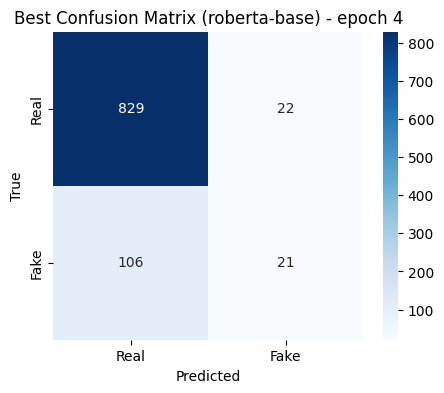


📊 STEP 3: Results Summary
🏅 Best F1 Score: 0.2471
🏆 Best Epoch: 4
💾 Model Saved: /content/drive/MyDrive/Fake_New_Detection_Project-20250906T205115Z-1-001/Fake_New_Detection_Project/NLP Project - Thay Khanh/ViFN-Vietnamese_Fake_New_Datasets_Ver3-main/RoBERTa_Model/roberta

📋 DETAILED METRICS - ROBERTA:
------------------------------------------------------------
ACCURACY       : 0.8691
PRECISION      : 0.8349
RECALL         : 0.8691
F1_WEIGHTED    : 0.8399
F1_MACRO       : 0.5877
AUC            : 0.8207

📋 Classification Report:
              precision    recall  f1-score   support

        Real     0.8866    0.9741    0.9283       851
        Fake     0.4884    0.1654    0.2471       127

    accuracy                         0.8691       978
   macro avg     0.6875    0.5698    0.5877       978
weighted avg     0.8349    0.8691    0.8399       978


📊 STEP 4: Visualization


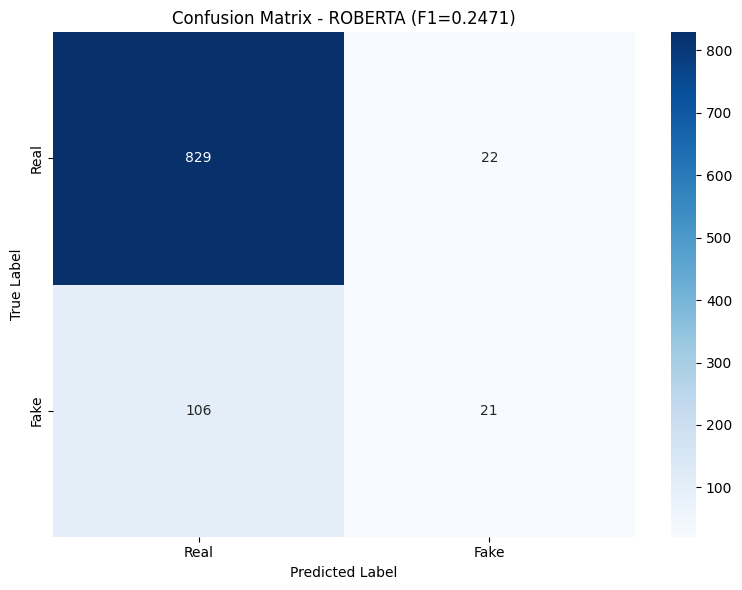

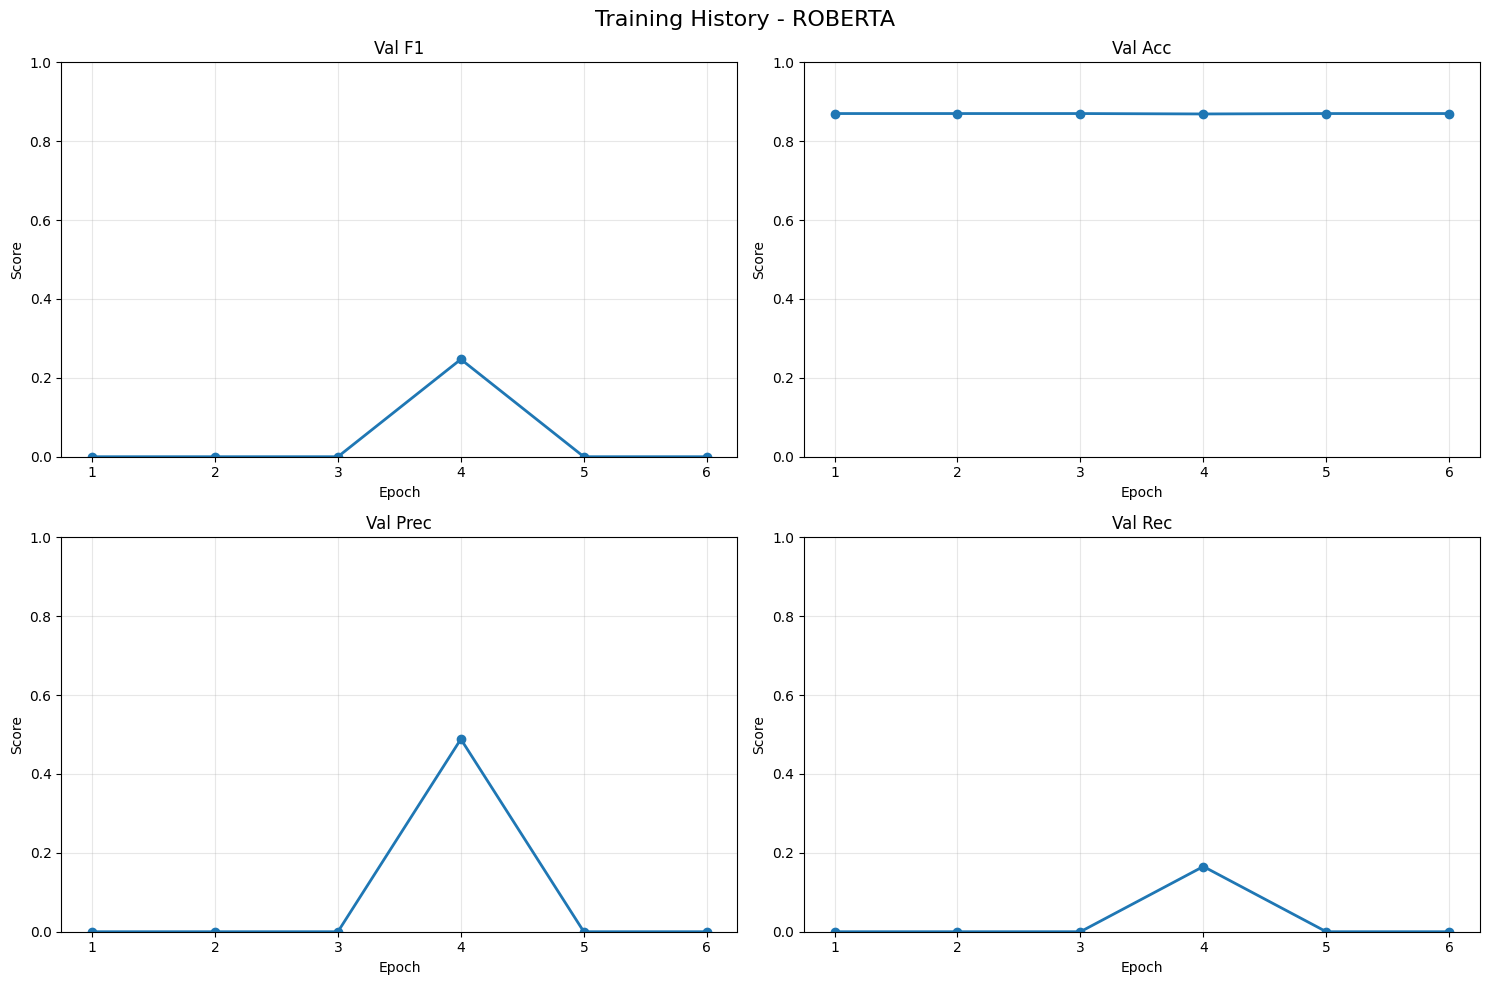


✅ TRAINING COMPLETED SUCCESSFULLY!
🎯 Final Model: ROBERTA
📈 Best Performance: F1=0.2471 at Epoch 4


In [13]:
# ===============================
# 🧪 CELL 11: ENHANCED MAIN EXECUTION
# ===============================

# --- Cấu hình ---
MODEL_NAME = "roberta"   # Thay đổi tại đây: 'phobert', 'bert', 'roberta', 'phobert_tfidf', 'phobert_w2v'
FAKE_PATH = "/content/drive/MyDrive/Fake_New_Detection_Project-20250906T205115Z-1-001/Fake_New_Detection_Project/NLP Project - Thay Khanh/ViFN-Vietnamese_Fake_New_Datasets_Ver3-main/processed/deduplicated_articles_fake.csv"
REAL_PATH = "/content/drive/MyDrive/Fake_New_Detection_Project-20250906T205115Z-1-001/Fake_New_Detection_Project/NLP Project - Thay Khanh/ViFN-Vietnamese_Fake_New_Datasets_Ver3-main/processed/deduplicated_articles_real.csv"
TEST_SIZE = 0.2
SAMPLE_SIZE = None  # None = full dataset, hoặc integer để test nhanh
BALANCE_DATA = False
NUM_EPOCHS = 15
BATCH_SIZE = 16
PATIENCE = 2
MODEL_SAVE_DIR = "/content/drive/MyDrive/Fake_New_Detection_Project-20250906T205115Z-1-001/Fake_New_Detection_Project/NLP Project - Thay Khanh/ViFN-Vietnamese_Fake_New_Datasets_Ver3-main/RoBERTa_Model"

def main():
    print("🚀 VIETNAMESE FAKE NEWS DETECTION - ENHANCED TRAINING PIPELINE")
    print("="*80)

    # Initialize pipeline
    pipeline = SingleModelPipeline()

    # Load and prepare data
    print("\n📂 STEP 1: Data Loading and Preparation")
    df = pipeline.load_data(FAKE_PATH, REAL_PATH)
    X_train, X_test, y_train, y_test = pipeline.prepare_and_split(
        df,
        test_size=TEST_SIZE,
        balance_data=BALANCE_DATA,
        sample_size=SAMPLE_SIZE
    )

    # Train model
    print(f"\n🤖 STEP 2: Training Model - {MODEL_NAME.upper()}")
    results = pipeline.train_single_model(
        MODEL_NAME,
        X_train, y_train, X_test, y_test,
        num_epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        patience=PATIENCE,
        save_best=True,
        model_save_dir=MODEL_SAVE_DIR,
        extra_init_kwargs={'from_scratch': True}
    )

    # Display results
    print(f"\n📊 STEP 3: Results Summary")
    print("="*80)
    print(f"🏅 Best F1 Score: {results['best_f1']:.4f}")
    print(f"🏆 Best Epoch: {results['best_epoch']}")
    print(f"💾 Model Saved: {results.get('saved_path', 'Not saved')}")

    # Show detailed metrics
    print(f"\n📋 DETAILED METRICS - {MODEL_NAME.upper()}:")
    print("-" * 60)
    metrics = results['metrics']
    for metric, value in metrics.items():
        if metric != 'classification_report':
            print(f"{metric.upper():15}: {value:.4f}")

    # Show classification report
    print(f"\n📋 Classification Report:")
    print(metrics['classification_report'])

    # Plot confusion matrix
    print(f"\n📊 STEP 4: Visualization")
    pipeline.plot_confusion_matrix(
        y_test,
        results['preds'],
        title=f'Confusion Matrix - {MODEL_NAME.upper()} (F1={results["best_f1"]:.4f})'
    )

    # Plot training history
    pipeline.plot_history(results.get('history'))

    print(f"\n✅ TRAINING COMPLETED SUCCESSFULLY!")
    print(f"🎯 Final Model: {MODEL_NAME.upper()}")
    print(f"📈 Best Performance: F1={results['best_f1']:.4f} at Epoch {results['best_epoch']}")

    return pipeline, results

# Run the main pipeline
if __name__ == "__main__":
    pipeline, results = main()


In [ ]:
# ===============================
# 🧪 CELL 12: ENHANCED TEST PREDICTIONS
# ===============================
def enhanced_test_predictions(pipeline):
    """Test the trained model with sample texts"""
    test_texts = [
        "Chính phủ Việt Nam công bố chính sách mới về phát triển kinh tế số trong năm 2024",
        "NÓNG: Phát hiện loại thực phẩm có thể chữa khỏi mọi bệnh ung thư chỉ trong 3 ngày!",
        "Nghiên cứu khoa học mới cho thấy tác động tích cực của việc tập thể dục đối với sức khỏe",
        "SHOCK: Trái đất sẽ kết thúc vào năm 2025 theo lời tiên tri cổ đại!"
    ]

    print(f"\n🧪 TESTING PREDICTIONS - {pipeline.model_name.upper()}")
    print("="*80)

    results_data = []
    for i, text in enumerate(test_texts, 1):
        try:
            pred, prob = pipeline.model.predict([text])
            if isinstance(pred, (list, np.ndarray)):
                pred = pred[0]
            if isinstance(prob, (list, np.ndarray)) and len(prob) > 0:
                if isinstance(prob[0], (list, np.ndarray)):
                    prob = prob[0]
                else:
                    prob = prob

            label = 'FAKE' if pred == 1 else 'REAL'
            confidence = np.max(prob) if hasattr(prob, '__len__') else prob

            print(f"\n📝 Test {i}: {text[:100]}{'...' if len(text) > 100 else ''}")
            print(f"🎯 Prediction: {label}")
            print(f"📊 Confidence: {confidence:.4f}")
            print(f"📈 Probabilities: Real={prob[0]:.4f}, Fake={prob[1]:.4f}")

            results_data.append({
                'Text_Preview': text[:120] + ('...' if len(text) > 120 else ''),
                'Prediction': label,
                'Confidence': f"{confidence:.4f}",
                'Real_Prob': f"{prob[0]:.4f}",
                'Fake_Prob': f"{prob[1]:.4f}"
            })

        except Exception as e:
            print(f"❌ Error predicting text {i}: {e}")
            results_data.append({
                'Text_Preview': text[:120] + ('...' if len(text) > 120 else ''),
                'Prediction': 'ERROR',
                'Confidence': '0.0000',
                'Real_Prob': '0.0000',
                'Fake_Prob': '0.0000'
            })

    # Display results table
    df_results = pd.DataFrame(results_data)
    print(f"\n📋 PREDICTION RESULTS SUMMARY:")
    print("="*80)
    display(df_results)

    return df_results

# Run test predictions
test_results = enhanced_test_predictions(pipeline)
